<a href="https://colab.research.google.com/github/Irene-kim/Cyberbullying-Detection-for-Women-/blob/master/codes)with_ELMo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization, Dropout
import tensorflow_hub as hub

import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, LSTM, Bidirectional, Reshape, Input, Lambda, Dropout, concatenate
from tensorflow.keras.models import Sequential
from keras import backend as K

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras.models import Model

from sklearn.metrics import roc_curve, roc_auc_score, auc

Using TensorFlow backend.


In [ ]:
# 2, 42, 123, 1208, 1996
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
seed = 1208
random.seed(seed) # Python
np.random.seed(seed) # numpy
# tf.random.set_seed(seed) # over Tensorflow 2.0
tf.set_random_seed(seed) # below Tensorflow 2.0
os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
sess = tf.Session()
K.set_session(sess)

elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
base_path = r'/content/gdrive/My Drive/Sk/categories'

In [ ]:
file_path = os.path.join(base_path, "Cyberbullying.csv")

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df = df[['Cyberbullying', 'Text']]
print(len(df))
df[:6]

7380


,Cyberbullying,Text
0,0,????????
1,0,Why these white girls SO salty in the comments...
2,0,Y these white ppl still on her ass like she??...
3,0,La jola??
4,0,follow me please I love your content please ????
5,0,Yesssssssssss bring it on baby girl


In [ ]:
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.strip().replace('\x80', "").replace('\x80', "")
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub("’", "'", text)
    return text

In [ ]:
df['Text'] = df['Text'].apply(cleanText)
filter = df['Text'] != ""
df = df[filter]
df[:5]

,Cyberbullying,Text
1,0,why these white girls so salty in the comments...
2,0,y these white ppl still on her ass like shes s...
3,0,la jola
4,0,follow me please i love your content please
5,0,yess bring it on baby girl


In [ ]:
df['Text'].nunique()

5100

In [ ]:
df.drop_duplicates(subset=['Text'], inplace=True)
df.head()

,Cyberbullying,Text
1,0,why these white girls so salty in the comments...
2,0,y these white ppl still on her ass like shes s...
3,0,la jola
4,0,follow me please i love your content please
5,0,yess bring it on baby girl


In [ ]:
input_data = df['Text']
output_data = df['Cyberbullying']

In [ ]:
input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=0.2, random_state= seed)

In [ ]:
input_train, input_val, output_train, output_val = train_test_split(input_train, output_train, test_size=0.25, random_state = seed)

In [ ]:
print(len(input_train))
print(len(input_val))
print(len(input_test))

3060
1020
1020


In [ ]:
print(input_train.shape)
print(input_test.shape)
print(output_train.shape)
print(output_test.shape)

(3060,)
(1020,)
(3060,)
(1020,)


In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
 
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), as_dict=True, signature="default")["default"]

def ELMoEmbedding2(input_text):
    return elmo(tf.reshape(tf.cast(input_text, tf.string), [-1]), signature="default", as_dict=True)["elmo"]

In [ ]:
def LSTM_model():
    input_layer = Input(shape=(1,), dtype="string", name="Input_layer")
    embedding_layer = Lambda(ELMoEmbedding2, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)
    Dropout_layer_1 = Dropout(0.25)(embedding_layer)
    LSTMs = LSTM(64, return_sequences= False, name="LSTM")(Dropout_layer_1)
    Dropout_layer_2 = Dropout(0.5)(LSTMs)
    output_layer = Dense(1, activation='sigmoid')(Dropout_layer_2)
    model = Model(inputs=[input_layer], outputs=output_layer, name="LSTM with ELMo Embeddings")
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc', f1, 'Precision', 'Recall', 'AUC'])
    return model 


def BLSTM_model():
    input_layer = Input(shape=(1,), dtype="string", name="Input_layer")
    embedding_layer = Lambda(ELMoEmbedding2, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)
    Dropout_layer_1 = Dropout(0.25)(embedding_layer)
    BiLSTM = Bidirectional(LSTM(64, return_sequences= False), name="BLSTM")(Dropout_layer_1)
    Dropout_layer_2 = Dropout(0.5)(BiLSTM)
    output_layer = Dense(1, activation='sigmoid')(Dropout_layer_2)
    model = Model(inputs=[input_layer], outputs=output_layer, name="BLSTM with ELMo Embeddings")
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc', f1, 'Precision', 'Recall', 'AUC'])
    return model 

def RNN_model():
    input_text = Input(shape=(1,), dtype=tf.string)
    embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    reshape = Reshape((1,1024))(embedding_layer)
    Dropout_layer_1 = Dropout(0.25)(reshape)
    hidden_layer = SimpleRNN(64)(Dropout_layer_1)
    Dropout_layer_2 = Dropout(0.50)(hidden_layer)
    output_layer = Dense(1, activation='sigmoid')(Dropout_layer_2)
    model = Model(inputs=[input_text], outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1, 'Precision', 'Recall', 'AUC'])
    return model

# def DNN_model():
#     input_text = Input(shape=(1,), dtype=tf.string, name="Input_Layer")
#     embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name = "ELMo_Embedding")(input_text)
#     hidden_layer = Dense(32, activation='relu')(embedding_layer)
#     Dropout_layer_1 = Dropout(0.5)(hidden_layer)
#     hidden_layer2 = Dense(32, activation='relu')(Dropout_layer_1)
#     Dropout_layer_2 = Dropout(0.5)(hidden_layer2)
#     output_layer = Dense(1, activation='sigmoid')(Dropout_layer_2)
#     model = Model(inputs=[input_text], outputs=output_layer, name="DNN with ELMo Embeddings")
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1, 'Precision', 'Recall', 'AUC'])
#     return model 

In [ ]:
model = BLSTM_model()
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "BLSTM with ELMo Embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
dropout (Dropout)            (None, None, 1024)        0         
_________________________________________________________________
BLSTM (Bidirectional)        (None, 128)               557568    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 557,697
Trainable params: 557,697
Non-trainable params: 0
__________________________________

In [ ]:
history = model.fit(input_train, output_train, epochs=4, batch_size=32, validation_data = (input_val, output_val),  verbose=1)

Train on 3060 samples, validate on 1020 samples
Epoch 1/4
3060/3060 [==============================] - 426s 139ms/sample - loss: 0.4446 - acc: 0.7840 - f1: 0.4815 - precision: 0.6305 - recall: 0.4271 - auc: 0.8170 - val_loss: 0.3805 - val_acc: 0.8284 - val_f1: 0.6358 - val_precision: 0.6781 - val_recall: 0.6124 - val_auc: 0.8703
Epoch 2/4
3060/3060 [==============================] - 412s 135ms/sample - loss: 0.3584 - acc: 0.8366 - f1: 0.6473 - precision: 0.7225 - recall: 0.6127 - auc: 0.8900 - val_loss: 0.3617 - val_acc: 0.8441 - val_f1: 0.6473 - val_precision: 0.7302 - val_recall: 0.6085 - val_auc: 0.8800
Epoch 3/4
3060/3060 [==============================] - 410s 134ms/sample - loss: 0.3104 - acc: 0.8683 - f1: 0.7139 - precision: 0.7849 - recall: 0.6862 - auc: 0.9177 - val_loss: 0.3623 - val_acc: 0.8520 - val_f1: 0.6579 - val_precision: 0.7560 - val_recall: 0.6124 - val_auc: 0.8800
Epoch 4/4
3060/3060 [==============================] - 391s 128ms/sample - loss: 0.2737 - acc: 0.8850 -

In [ ]:
y_pred = model.evaluate(input_test, output_test)
y_pred

1020/1020 [==============================] - 93s 91ms/sample - loss: 0.3343 - acc: 0.8461 - f1: 0.7054 - precision: 0.7218 - recall: 0.6982 - auc: 0.9119


[0.3343492133360283, 0.84607846, 0.7053731, 0.7218045, 0.6981818, 0.91185355]

In [ ]:
y_pred = model.predict(input_test)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(output_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9118682123245881

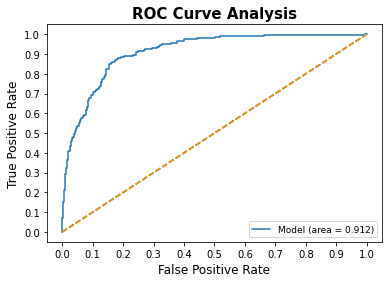

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=12)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=12)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':9}, loc='lower right')

plt.show()
#plt.savefig(".jpg")

In [ ]:
y_pred_binary = []

In [ ]:
for pred in y_pred:
    if pred > 0.5:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

In [ ]:
print(classification_report(output_test, y_pred_binary, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       745
           1       0.72      0.70      0.71       275

    accuracy                           0.85      1020
   macro avg       0.81      0.80      0.80      1020
weighted avg       0.84      0.85      0.85      1020

